# Exploratory Data Analysis for Small Business Performance Prediction

## Overview

In this notebook, we will perform exploratory data analysis and model building for small business performance prediction. Our goal is to build predictive models to classify whether a business is open or closed based on these features. We will employ Decision Trees and K-Nearest Neighbors, and evaluate their performance using classification reports and confusion matrices.

## Data Processing Steps

1. Load the dataset and inspect its structure.
2. Drop missing values and irrelevant columns.
3. Normalize numerical features.
4. Split the dataset into training and testing sets (80% train, 20% test).


## Results

Both models seem to predict true positives well (businesses that are open) but struggle with true negatives (businesses that are closed). This suggests that we may need additional features, such as review sentiment, business age, and income, to improve the models' ability to identify closed businesses accurately.

In [42]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/business_economic_data.csv')
df

business_id  ...           gdp
0       Pns2l4eNsfO8kk83dixA6A  ...  3.199681e+07
1       Pns2l4eNsfO8kk83dixA6A  ...  1.164610e+02
2       Pns2l4eNsfO8kk83dixA6A  ...  3.851246e+07
3       mpf3x-BjTdTEA3yCZrAYPw  ...  9.184719e+07
4       mpf3x-BjTdTEA3yCZrAYPw  ...  1.156970e+02
...                        ...  ...           ...
439591  mtGm22y5c2UHNXDFAjaPNw  ...  1.006750e+02
439592  mtGm22y5c2UHNXDFAjaPNw  ...  1.457245e+07
439593  jV_XOycEzSlTx-65W906pg  ...  1.157729e+08
439594  jV_XOycEzSlTx-65W906pg  ...  1.322690e+02
439595  jV_XOycEzSlTx-65W906pg  ...  1.414246e+08

[439596 rows x 21 columns]

In [43]:
# 1. Display basic information about the dataset
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())
print("Data types:\n", df.dtypes)

Dataset shape: (439596, 21)
Columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours', 'geometry', 'FIPS5', 'labor_force', 'employed', 'unemployed', 'unemployment_rate', 'gdp']
Missing values per column:
 business_id              0
name                     0
address              15249
city                     0
state                    0
postal_code            181
latitude                 0
longitude                0
stars                    0
review_count             0
is_open                  0
attributes           39994
categories             307
hours                67491
geometry                 0
FIPS5                 5721
labor_force           5721
employed              5721
unemployed            5721
unemployment_rate     5721
gdp                   5721
dtype: int64
Data types:
 business_id           object
name                  object
address               object


In [44]:
# 2. Summary statistics for covariates
COVARS = ['labor_force', 'employed', 'unemployed', 'unemployment_rate', 'gdp']
print("\nSummary statistics for covariates:")
df[COVARS].describe()


Summary statistics for covariates:


labor_force       employed  ...  unemployment_rate           gdp
count  433875.000000  433875.000000  ...      433875.000000  4.338750e+05
mean   424887.692439  410219.254237  ...           3.476155  4.572722e+07
std    215210.341653  207515.875385  ...           0.629904  4.596713e+07
min      1306.000000    1241.000000  ...           2.200000  6.589600e+01
25%    264836.000000  253239.000000  ...           3.000000  1.239910e+02
50%    410190.000000  399310.000000  ...           3.400000  3.262478e+07
75%    507381.000000  493316.000000  ...           4.100000  8.752909e+07
max    801413.000000  777140.000000  ...           7.900000  1.414246e+08

[8 rows x 5 columns]

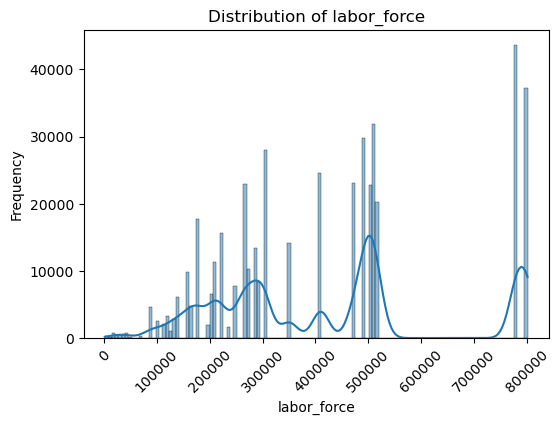

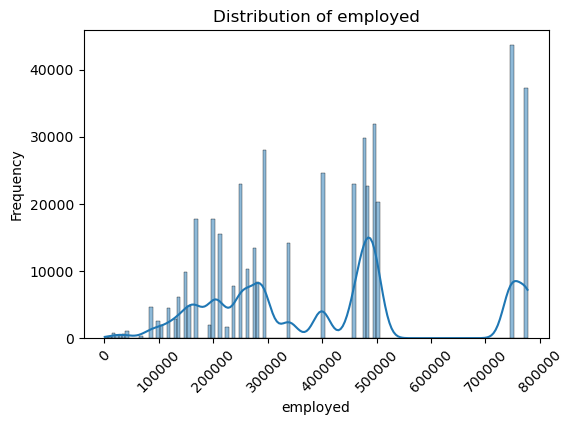

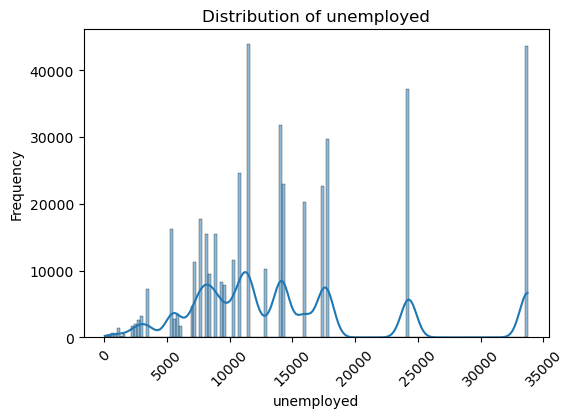

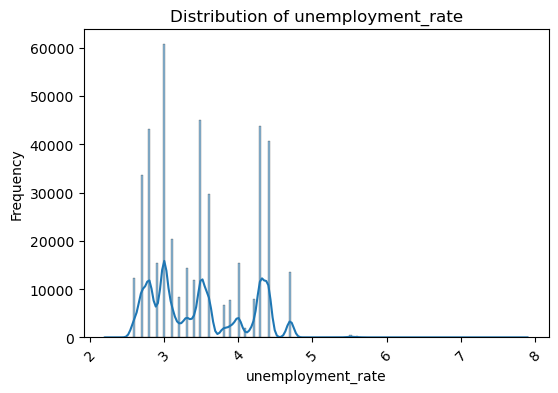

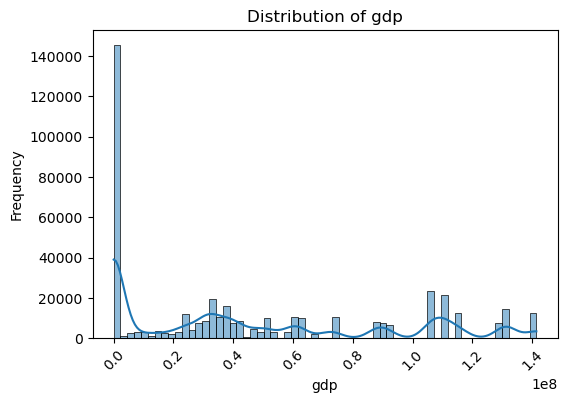

In [45]:
# 2.1 Visualize distributions of covariates
for covar in COVARS:
    plt.figure(figsize=(6,4))
    # Rotate x-ticks for better readability
    sns.histplot(df[covar].dropna(), kde=True)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {covar}')
    plt.xlabel(covar)
    plt.ylabel('Frequency')
    plt.show()

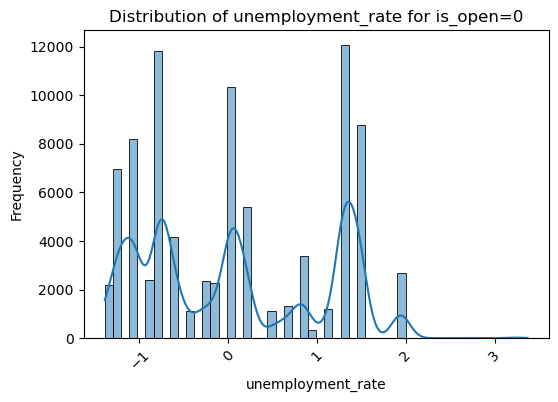

In [ ]:
# 2.2 Distribution of covariates by target variable

for covar in COVARS:
    for is_open in [0, 1]:
        subset = df[df['is_open'] == is_open][covar].dropna()
        plt.figure(figsize=(6,4))
        sns.histplot(subset, kde=True)
        plt.xticks(rotation=45)
        plt.title(f'Distribution of {covar} for is_open={is_open}')
        plt.xlabel(covar)
        plt.ylabel('Frequency')
        plt.show()

In [46]:
# 3. Summary statistics for target variable
TARGETS = ['is_open', 'review_count', 'stars']
print("\nSummary statistics for target variables:")
df[TARGETS].describe()


Summary statistics for target variables:


is_open   review_count          stars
count  439596.000000  439596.000000  439596.000000
mean        0.796554      45.508449       3.600417
std         0.402562     122.479222       0.976057
min         0.000000       5.000000       1.000000
25%         1.000000       8.000000       3.000000
50%         1.000000      15.000000       3.500000
75%         1.000000      38.000000       4.500000
max         1.000000    7568.000000       5.000000

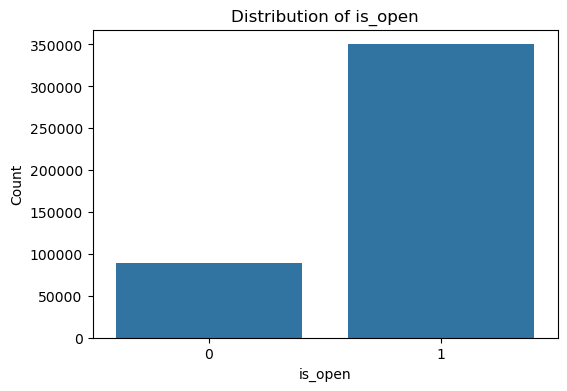

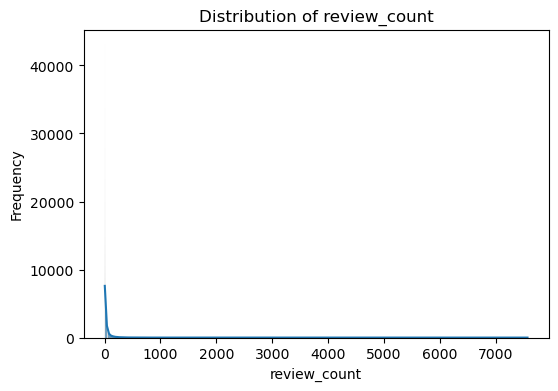

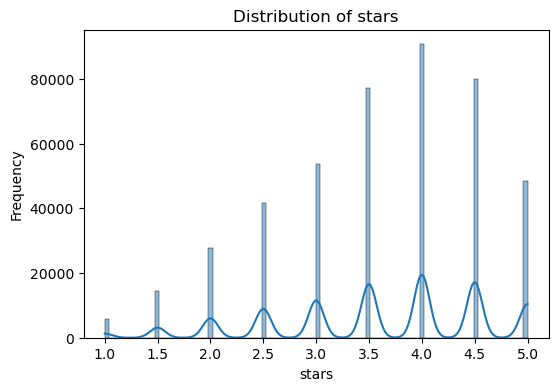

In [47]:
# 3.1 Visualize distribution of target variable
for target in TARGETS:
    if target == 'is_open':
        plt.figure(figsize=(6,4))
        sns.countplot(x=df[target])
        plt.title(f'Distribution of {target}')
        plt.xlabel(target)
        plt.ylabel('Count')
    else:
        plt.figure(figsize=(6,4))
        sns.histplot(df[target].dropna(), kde=True)
        plt.title(f'Distribution of {target}')
        plt.xlabel(target)
        plt.ylabel('Frequency')
    plt.show()

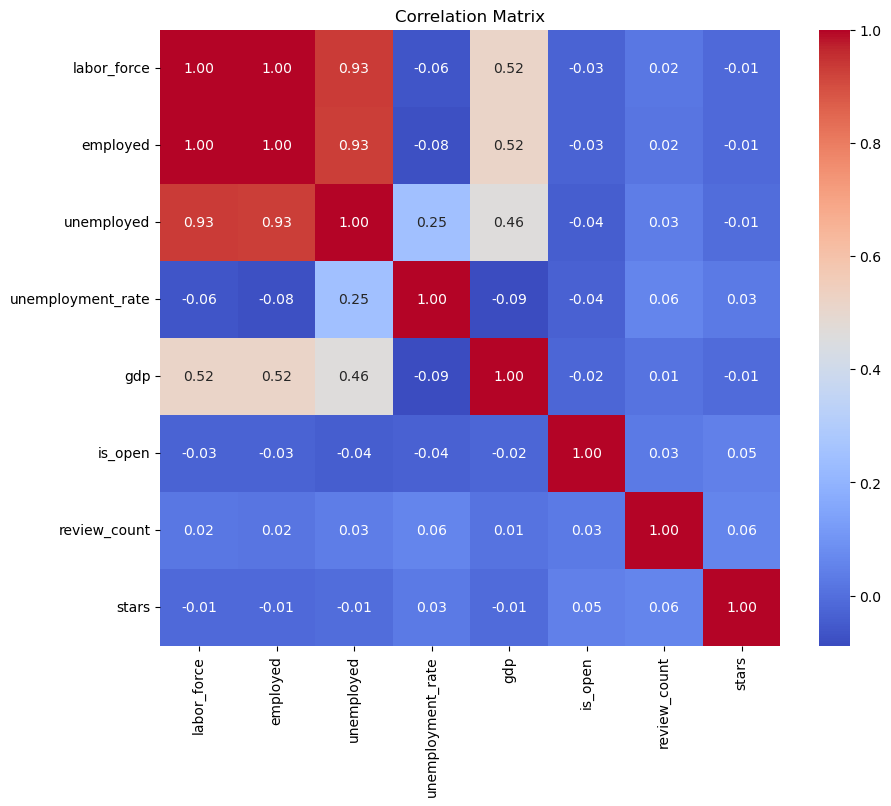

In [48]:
# 4. Correlation analysis
correlation_matrix = df[COVARS + TARGETS].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

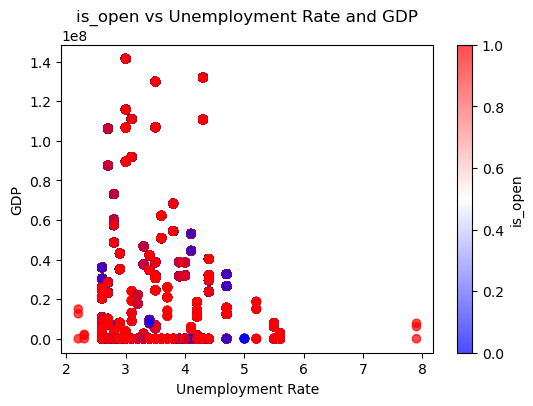

In [49]:
# 5. Scatter plots to visualize relationships
plt.figure(figsize=(6,4))
plt.scatter(df['unemployment_rate'], df['gdp'], c=df['is_open'], cmap='bwr', alpha=0.7)
plt.colorbar(label='is_open')
plt.xlabel('Unemployment Rate')
plt.ylabel('GDP')
plt.title('is_open vs Unemployment Rate and GDP')
plt.show()

In [50]:
# 6. Preprocessing for model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
COVARS = ['unemployment_rate', 'gdp', 'review_count', 'stars']
df = df.dropna(subset=COVARS + ['is_open'])

df[COVARS] = scaler.fit_transform(df[COVARS])

X = df[COVARS]
y = df['is_open']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_50901/3477491736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[COVARS] = scaler.fit_transform(df[COVARS])


In [51]:
# 6. Fit preliminary Decision Tree and K-Nearest-Neighbors Model

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dtc, zero_division=np.nan))

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("\nK-Nearest Neighbors Classification Report:\n", classification_report(y_test, y_pred_knn, zero_division=np.nan))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.13      0.18     17556
           1       0.81      0.93      0.87     69219

    accuracy                           0.77     86775
   macro avg       0.57      0.53      0.53     86775
weighted avg       0.71      0.77      0.73     86775


K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.08      0.13     17556
           1       0.80      0.95      0.87     69219

    accuracy                           0.77     86775
   macro avg       0.54      0.52      0.50     86775
weighted avg       0.70      0.77      0.72     86775



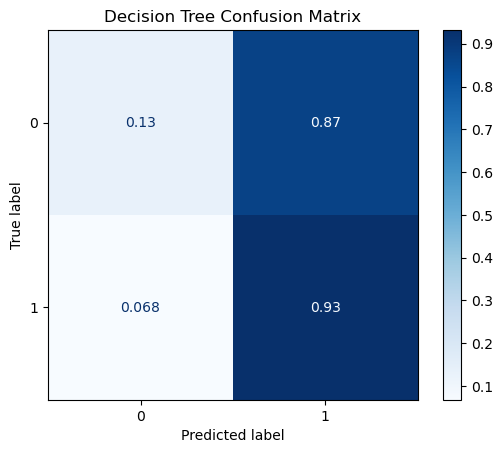

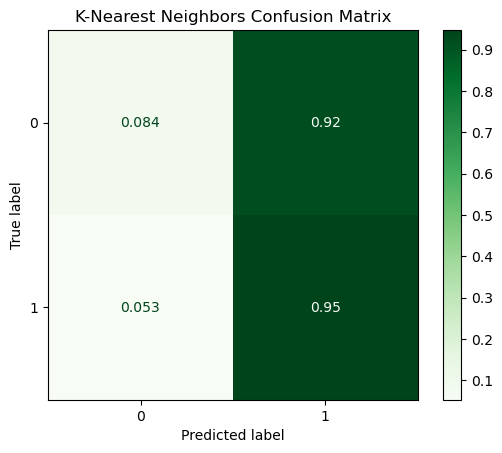

In [52]:
# 6.2 Confusion matrices for both models
from sklearn.metrics import ConfusionMatrixDisplay

disp_dct = ConfusionMatrixDisplay.from_estimator(dtc, X_test, y_test, cmap='Blues', normalize='true')
plt.title('Decision Tree Confusion Matrix')
plt.show()

disp_knn = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap='Greens', normalize='true')
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.show()